<a href="https://colab.research.google.com/github/Madhukiranchiti/RTML-trial/blob/main/MLP_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1: Fashion and Housing Multi-layer Perceptron Model Training
## Course : Real-Time Machine Learning - ECGR 5106
### Name : Madhu Kiran Rao Chiti
### Student ID : 801333676
### Date : 01/26/2024


In [17]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset

from torchvision import transforms, datasets
!pip install torchmetrics
from torchmetrics.classification import MulticlassAccuracy, BinaryAccuracy
from torchmetrics import ConfusionMatrix

import copy

In [18]:
class Train_Model: # A class to train and save the developed model and the metrics


    def __init__(self, model, loss, optimizer, accuracy, model_type, device, classes=0):

        self.device = device
        self.model = model.to(device) ## Setting the model on GPU
        self.Loss_Function = loss
        self.optimizer = optimizer
        self.accuracy = accuracy
        self.model_type = model_type
        self.classNum = classes

        # A dictionary to append or store the results
        self.Metrics = {"Training_Loss":[],"Training_Accuracy":[], "Validation_Loss":[], "Validation_Accuracy":[],"Test_Accuracy":0}
        self.ConfMatrix = None

    # Function to train the model
    def model_run(self, l_data,run_type):

        if run_type == 'train':
          self.model.train()

          if self.model_type == "Classification":
              MCA = self.accuracy(self.classNum)
          else:
              MCA = self.accuracy

          loss_sum = 0
          acc = 0

          # Iterates over the data
          for data, labels in tqdm(l_data):

              # transform data into one-hot vectors
              data = data.to(self.device)
              if self.model_type == "Classification":
                  labels = torch.eye(10)[labels]
              else:
                  labels = labels.reshape(-1, 1)
              labels = labels.to(self.device)

              predictions = self.model(data)
              loss_value = self.Loss_Function(predictions, labels)


              self.optimizer.zero_grad()
              loss_value.backward()
              self.optimizer.step()


              # Set the predictions and labels back into integers for accuracy calculation
              if self.model_type == "Classification":
                  predictions = torch.Tensor([torch.argmax(i).item() for i in predictions])
                  labels = torch.Tensor([torch.argmax(i).item() for i in labels])

              ##### Calculate Loss and accuracy
              loss_sum += loss_value.item()
              if self.model_type == "Classification":
                  acc += MCA(predictions, labels)

          self.Metrics["Training_Loss"].append(loss_sum / len(l_data))
          if self.model_type == "Classification":
              self.Metrics["Training_Accuracy"].append(acc / len(l_data))


        elif run_type == 'eval':
          self.model.eval()

          if self.model_type == "Classification":
              MCA = self.accuracy(self.classNum)
          else:
              MCA = self.accuracy

          loss_sum = 0
          acc = 0

          for data, labels in l_data:

              data = data.to(self.device)
              if self.model_type == "Classification":
                  labels = torch.eye(10)[labels]
              else:
                  labels = labels.reshape(-1, 1)
              labels = labels.to(self.device)

              with torch.no_grad():
                  predictions = self.model(data)
              loss_value = self.Loss_Function(predictions, labels)

              if self.model_type == "Classification":
                  predictions = torch.Tensor([torch.argmax(i).item() for i in predictions])
                  labels = torch.Tensor([torch.argmax(i).item() for i in labels])

              loss_sum += loss_value.item()
              if self.model_type == "Classification":
                  acc += MCA(predictions, labels)

          self.Metrics["Validation_Loss"].append(loss_sum / len(l_data))
          if self.model_type == "Classification":
              self.Metrics["Validation_Accuracy"].append(acc / len(l_data))


    def fit(self, t_data, v_data, EPOCHS):


        for i in range(EPOCHS):

            self.model_run(v_data,'eval')
            self.model_run(t_data,'train')

            print("Current Epoch:", i+1)
            print("Training_Loss:", self.Metrics["Training_Loss"][-1], " | Validation_Loss:", self.Metrics["Validation_Loss"][-1])
            if self.model_type == "Classification":
                print("Training_Accuracy:", self.Metrics["Training_Accuracy"][-1].item(), " | Validation_Accuracy:", self.Metrics["Validation_Accuracy"][-1].item())


    def Test_Model(self, testLoader):

        self.model.eval()

        if self.model_type == "Classification":
            confusion = ConfusionMatrix(task="multiclass", num_classes=self.classNum)
            MCA = self.accuracy(self.classNum)
        else:
            MCA = self.accuracy

        predMax = torch.empty(0)
        labelMax = torch.empty(0)

        for data, labels in testLoader:

            data = data.to(self.device)
            if self.model_type == "Classification":
                labels = torch.eye(10)[labels]
            else:
                labels = labels.reshape(-1, 1)
            labels = labels.to(self.device)

            with torch.no_grad():
                pred = self.model(data)

            if self.model_type == "Classification":
                pred = torch.Tensor([torch.argmax(i).item() for i in pred])
                labels = torch.Tensor([torch.argmax(i).item() for i in labels])

            predMax = torch.cat((predMax, pred))
            labelMax = torch.cat((labelMax, labels))

        if self.model_type == "Classification":
            self.ConfMatrix = confusion(predMax, labelMax)
            self.Metrics["Test_Accuracy"] = MCA(predMax, labelMax).item()




## Problem 1 Fashion Dataset

In [19]:
device_to_use = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
train_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.29), (0.32)),
])

test_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.29), (0.32)),
])

In [21]:
train_df = datasets.FashionMNIST(root="datasets", train=True, transform=train_transform,download=True)
test_df = datasets.FashionMNIST(root="datasets", train=False, transform=test_transform,download=True)

## Create Train and Test data
validNum = int(len(train_df) * 0.8)
train_df, valid_df = random_split(train_df, [validNum, len(train_df) - validNum])


In [22]:
trainLoader = DataLoader(train_df, batch_size=256, shuffle=True, num_workers=1)
validateLoader = DataLoader(valid_df, batch_size=256, shuffle=True, num_workers=1)
testLoader = DataLoader(test_df, batch_size=256, shuffle=True, num_workers=1)

In [23]:
BaseModel = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.Linear(in_features= 256, out_features= 128),
    nn.ReLU(),
    nn.Linear(in_features= 128, out_features= 64),
    nn.ReLU(),
    nn.Linear(in_features= 64, out_features= 10),
)

In [24]:
base = copy.deepcopy(BaseModel)
baseline_model_generator = Train_Model(base, nn.CrossEntropyLoss(), torch.optim.SGD(base.parameters(), lr=0.01, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

### 1.a Train the model from scratch (with randomized parameters)

100%|██████████| 188/188 [00:21<00:00,  8.64it/s]

Current Epoch: 1
Training_Loss: 0.9965518630565481  | Validation_Loss: 2.305695026478869
Training_Accuracy: 0.6533576250076294  | Validation_Accuracy: 0.07300763577222824



100%|██████████| 188/188 [00:12<00:00, 15.21it/s]

Current Epoch: 2
Training_Loss: 0.47451142586292105  | Validation_Loss: 0.5183095183778317
Training_Accuracy: 0.8277556896209717  | Validation_Accuracy: 0.8145686984062195



100%|██████████| 188/188 [00:12<00:00, 15.37it/s]

Current Epoch: 3
Training_Loss: 0.4132389026753446  | Validation_Loss: 0.4526555988382786
Training_Accuracy: 0.8513217568397522  | Validation_Accuracy: 0.8356159925460815



100%|██████████| 188/188 [00:12<00:00, 15.35it/s]

Current Epoch: 4
Training_Loss: 0.37425542765475334  | Validation_Loss: 0.4125966106323486
Training_Accuracy: 0.8644177317619324  | Validation_Accuracy: 0.8516023755073547



100%|██████████| 188/188 [00:12<00:00, 15.41it/s]

Current Epoch: 5
Training_Loss: 0.3550823284907544  | Validation_Loss: 0.3843499567914516
Training_Accuracy: 0.8701916933059692  | Validation_Accuracy: 0.860486626625061



100%|██████████| 188/188 [00:13<00:00, 13.48it/s]

Current Epoch: 6
Training_Loss: 0.33368122411218093  | Validation_Loss: 0.35919896402257556
Training_Accuracy: 0.8790460824966431  | Validation_Accuracy: 0.8722372055053711



100%|██████████| 188/188 [00:12<00:00, 15.10it/s]

Current Epoch: 7
Training_Loss: 0.3178531958701763  | Validation_Loss: 0.3474826584471033
Training_Accuracy: 0.8843581080436707  | Validation_Accuracy: 0.8756680488586426



100%|██████████| 188/188 [00:12<00:00, 15.01it/s]

Current Epoch: 8
Training_Loss: 0.29787504736413345  | Validation_Loss: 0.3395947756919455
Training_Accuracy: 0.8920930027961731  | Validation_Accuracy: 0.8746490478515625



100%|██████████| 188/188 [00:12<00:00, 14.87it/s]

Current Epoch: 9
Training_Loss: 0.28927288569034415  | Validation_Loss: 0.3382274692362927
Training_Accuracy: 0.8944308757781982  | Validation_Accuracy: 0.8801321387290955



100%|██████████| 188/188 [00:13<00:00, 14.43it/s]

Current Epoch: 10
Training_Loss: 0.27460739286021985  | Validation_Loss: 0.3439605083871395
Training_Accuracy: 0.8990411758422852  | Validation_Accuracy: 0.8744328022003174



100%|██████████| 188/188 [00:12<00:00, 14.84it/s]

Current Epoch: 11
Training_Loss: 0.2646077275276184  | Validation_Loss: 0.32605211214816315
Training_Accuracy: 0.9030353426933289  | Validation_Accuracy: 0.8824192881584167



100%|██████████| 188/188 [00:12<00:00, 15.11it/s]

Current Epoch: 12
Training_Loss: 0.2568572179434147  | Validation_Loss: 0.3179717089267487
Training_Accuracy: 0.9053789377212524  | Validation_Accuracy: 0.8885537981987



100%|██████████| 188/188 [00:12<00:00, 15.09it/s]

Current Epoch: 13
Training_Loss: 0.24316254377048066  | Validation_Loss: 0.3322069378609353
Training_Accuracy: 0.9106070399284363  | Validation_Accuracy: 0.8814443349838257



100%|██████████| 188/188 [00:12<00:00, 14.82it/s]

Current Epoch: 14
Training_Loss: 0.2333174022112755  | Validation_Loss: 0.30995579285824554
Training_Accuracy: 0.9135340452194214  | Validation_Accuracy: 0.8896418809890747



100%|██████████| 188/188 [00:12<00:00, 15.26it/s]

Current Epoch: 15
Training_Loss: 0.2273696596001057  | Validation_Loss: 0.3287394509670582
Training_Accuracy: 0.9151701331138611  | Validation_Accuracy: 0.8825483918190002



100%|██████████| 188/188 [00:12<00:00, 15.21it/s]

Current Epoch: 16
Training_Loss: 0.21677611253045975  | Validation_Loss: 0.3176461099944216
Training_Accuracy: 0.9198825359344482  | Validation_Accuracy: 0.8856441974639893



100%|██████████| 188/188 [00:12<00:00, 14.97it/s]

Current Epoch: 17
Training_Loss: 0.21771184315389774  | Validation_Loss: 0.332206129710725
Training_Accuracy: 0.9205544590950012  | Validation_Accuracy: 0.877150297164917



100%|██████████| 188/188 [00:12<00:00, 15.02it/s]

Current Epoch: 18
Training_Loss: 0.1991376784491412  | Validation_Loss: 0.3080418347678286
Training_Accuracy: 0.9265872836112976  | Validation_Accuracy: 0.8900337219238281



100%|██████████| 188/188 [00:12<00:00, 14.91it/s]

Current Epoch: 19
Training_Loss: 0.19104404814858386  | Validation_Loss: 0.31563932844933046
Training_Accuracy: 0.930055558681488  | Validation_Accuracy: 0.891466498374939



100%|██████████| 188/188 [00:12<00:00, 14.71it/s]

Current Epoch: 20
Training_Loss: 0.1871084526498267  | Validation_Loss: 0.3290244759397304
Training_Accuracy: 0.9320927858352661  | Validation_Accuracy: 0.8856996297836304



Test Accuracy: 0.876800000667572 
Time to Train: 0:05:22.806689


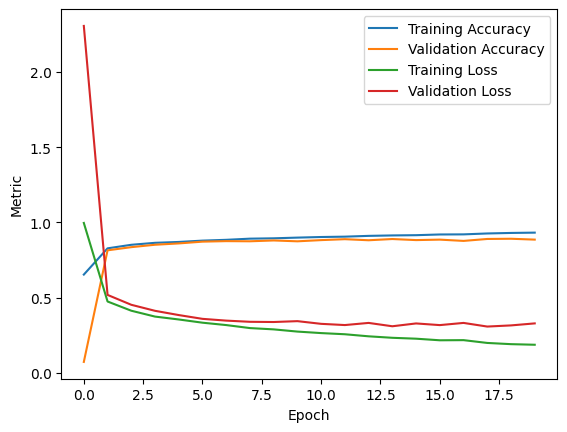

In [10]:
start_time = datetime.now()

baseline_model_generator.fit(trainLoader, validateLoader,
                             20)
end_time = datetime.now()
baseline_model_generator.Test_Model(testLoader)

print("\nTest Accuracy:", baseline_model_generator.Metrics["Test_Accuracy"], "\nTime to Train:", end_time - start_time)
import matplotlib.pyplot as plt

### PLOTTING METRICS
plt.plot(baseline_model_generator.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(baseline_model_generator.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(baseline_model_generator.Metrics['Training_Loss'], label='Training Loss')
plt.plot(baseline_model_generator.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

In [11]:
# Increased depth and width
ComplexModel = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=10),
)
complex_model = copy.deepcopy(ComplexModel)


In [12]:
complex_m = copy.deepcopy(ComplexModel)
complex_model_generator = Train_Model(complex_m, nn.CrossEntropyLoss(), torch.optim.SGD(complex_m.parameters(), lr=0.01, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

100%|██████████| 188/188 [00:13<00:00, 14.45it/s]

Current Epoch: 1
Training_Loss: 1.2937736720480817  | Validation_Loss: 2.304798384930225
Training_Accuracy: 0.5568025708198547  | Validation_Accuracy: 0.13205842673778534



100%|██████████| 188/188 [00:12<00:00, 14.97it/s]

Current Epoch: 2
Training_Loss: 0.5312046388045271  | Validation_Loss: 0.593042993799169
Training_Accuracy: 0.8066989183425903  | Validation_Accuracy: 0.7827747464179993



100%|██████████| 188/188 [00:12<00:00, 14.76it/s]

Current Epoch: 3
Training_Loss: 0.42796649942372705  | Validation_Loss: 0.4584971717063417
Training_Accuracy: 0.8445535898208618  | Validation_Accuracy: 0.8304393291473389



100%|██████████| 188/188 [00:12<00:00, 15.06it/s]

Current Epoch: 4
Training_Loss: 0.38038647618699584  | Validation_Loss: 0.40849661002767845
Training_Accuracy: 0.8618348836898804  | Validation_Accuracy: 0.8522859215736389



100%|██████████| 188/188 [00:12<00:00, 14.85it/s]

Current Epoch: 5
Training_Loss: 0.3513187372938116  | Validation_Loss: 0.378671148355971
Training_Accuracy: 0.873492956161499  | Validation_Accuracy: 0.8660114407539368



100%|██████████| 188/188 [00:15<00:00, 12.46it/s]


Current Epoch: 6
Training_Loss: 0.3303688227179203  | Validation_Loss: 0.365194227467192
Training_Accuracy: 0.881794273853302  | Validation_Accuracy: 0.8643696308135986


100%|██████████| 188/188 [00:14<00:00, 13.27it/s]

Current Epoch: 7
Training_Loss: 0.30792854916542134  | Validation_Loss: 0.3501115637890836
Training_Accuracy: 0.8885189890861511  | Validation_Accuracy: 0.8722237944602966



100%|██████████| 188/188 [00:12<00:00, 15.29it/s]

Current Epoch: 8
Training_Loss: 0.29126678320004584  | Validation_Loss: 0.351764330204497
Training_Accuracy: 0.8936163187026978  | Validation_Accuracy: 0.8750581741333008



100%|██████████| 188/188 [00:12<00:00, 15.16it/s]

Current Epoch: 9
Training_Loss: 0.2793359549597223  | Validation_Loss: 0.3298594460208365
Training_Accuracy: 0.8972482085227966  | Validation_Accuracy: 0.8777852058410645



100%|██████████| 188/188 [00:12<00:00, 15.16it/s]

Current Epoch: 10
Training_Loss: 0.2634627261852964  | Validation_Loss: 0.3464110344648361
Training_Accuracy: 0.9034388661384583  | Validation_Accuracy: 0.8765068054199219



100%|██████████| 188/188 [00:12<00:00, 14.75it/s]

Current Epoch: 11
Training_Loss: 0.2502408766366066  | Validation_Loss: 0.33593668202136423
Training_Accuracy: 0.9068446755409241  | Validation_Accuracy: 0.8789477944374084



100%|██████████| 188/188 [00:12<00:00, 14.65it/s]

Current Epoch: 12
Training_Loss: 0.23612873541547896  | Validation_Loss: 0.3198221595363414
Training_Accuracy: 0.9134793281555176  | Validation_Accuracy: 0.884709358215332



100%|██████████| 188/188 [00:12<00:00, 15.00it/s]

Current Epoch: 13
Training_Loss: 0.23015564394758103  | Validation_Loss: 0.31205728111114905
Training_Accuracy: 0.917685329914093  | Validation_Accuracy: 0.8904372453689575



100%|██████████| 188/188 [00:13<00:00, 14.29it/s]

Current Epoch: 14
Training_Loss: 0.21824912845771363  | Validation_Loss: 0.3075482426805699
Training_Accuracy: 0.919514000415802  | Validation_Accuracy: 0.8891183733940125



100%|██████████| 188/188 [00:12<00:00, 14.97it/s]

Current Epoch: 15
Training_Loss: 0.20644081074823725  | Validation_Loss: 0.31511511289058847
Training_Accuracy: 0.9248381853103638  | Validation_Accuracy: 0.8905988931655884



100%|██████████| 188/188 [00:12<00:00, 14.92it/s]

Current Epoch: 16
Training_Loss: 0.19996296075430323  | Validation_Loss: 0.3194740281460133
Training_Accuracy: 0.9271935820579529  | Validation_Accuracy: 0.8907185792922974



100%|██████████| 188/188 [00:12<00:00, 15.00it/s]

Current Epoch: 17
Training_Loss: 0.18603716430036313  | Validation_Loss: 0.32891641145056866
Training_Accuracy: 0.9315397143363953  | Validation_Accuracy: 0.8836591839790344



100%|██████████| 188/188 [00:12<00:00, 14.86it/s]

Current Epoch: 18
Training_Loss: 0.1828148633320915  | Validation_Loss: 0.3188747101007624
Training_Accuracy: 0.9329761862754822  | Validation_Accuracy: 0.8881409168243408



100%|██████████| 188/188 [00:12<00:00, 14.80it/s]

Current Epoch: 19
Training_Loss: 0.17735475559342415  | Validation_Loss: 0.32617660722833997
Training_Accuracy: 0.9349329471588135  | Validation_Accuracy: 0.8891366720199585



100%|██████████| 188/188 [00:12<00:00, 14.79it/s]

Current Epoch: 20
Training_Loss: 0.16098146735036628  | Validation_Loss: 0.37634099576067415
Training_Accuracy: 0.9407824873924255  | Validation_Accuracy: 0.8750181794166565



Test Accuracy: 0.8857999444007874 
Time to Train: 0:05:20.589092


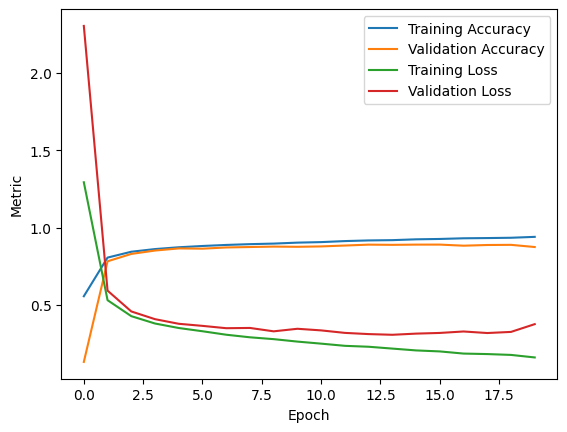

In [13]:
start_time = datetime.now()

complex_model_generator.fit(trainLoader, validateLoader,
                            20 )
end_time = datetime.now()
complex_model_generator.Test_Model(testLoader)

print("\nTest Accuracy:", complex_model_generator.Metrics["Test_Accuracy"], "\nTime to Train:", end_time - start_time)
import matplotlib.pyplot as plt

### PLOTTING METRICS
plt.plot(complex_model_generator.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(complex_model_generator.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(complex_model_generator.Metrics['Training_Loss'], label='Training Loss')
plt.plot(complex_model_generator.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

### Does your network need more epochs for full training? Do you observe overfitting?
We see that the validation loss hasn't shown any major change over the 20 epochs where as the training loss has reduced which means that the model is performing better on the training dataset but not the validation dataset resulting in overfitting.


## Problem 2 Housing Predictions

In [14]:
device_to_use = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
train_df = pd.read_csv("/content/datasets/house-train.csv")
test_df = pd.read_csv("/content/datasets/house-test.csv")
display(train_df.head()),display(test_df.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


(None, None)

In [33]:
def data_preprocessor_a(train_data, test_data, label='SalePrice'):

    features_all = pd.concat((train_data.drop(columns=['Id', label]), test_data.drop(columns=['Id'])))
    numeric_features = features_all.dtypes[features_all.dtypes != 'object'].index

    features_all[numeric_features] = features_all[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
    features_all[numeric_features] = features_all[numeric_features].fillna(0)
    #features_all = pd.get_dummies(features_all, dummy_na=True)

    train_df = features_all[:train_data.shape[0]].copy()

    normVals = (train_data[label].mean(), train_data[label].std())
    print(normVals)

    train_df[label] = ( train_data[label] - normVals[0] ) / normVals[1]
    test_df = features_all[train_data.shape[0]:].copy()

    return train_df, test_df




In [34]:
def data_preprocessor_b(train_data, test_data, label='SalePrice'):

    features_all = pd.concat((train_data.drop(columns=['Id', label]), test_data.drop(columns=['Id'])))
    numeric_features = features_all.dtypes[features_all.dtypes != 'object'].index

    features_all[numeric_features] = features_all[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
    features_all[numeric_features] = features_all[numeric_features].fillna(0)
    features_all = pd.get_dummies(features_all, dummy_na=True)

    train_df = features_all[:train_data.shape[0]].copy()

    normVals = (train_data[label].mean(), train_data[label].std())
    print(normVals)

    train_df[label] = ( train_data[label] - normVals[0] ) / normVals[1]
    test_df = features_all[train_data.shape[0]:].copy()

    return train_df, test_df

In [35]:
lectureModel = nn.Sequential(
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.LazyLinear(10),
)


class sale_predictor(nn.Module):
    def __init__(self):
        super(sale_predictor, self).__init__()

        # From output data
        self.mean = 180921.19589041095
        self.std = 79442.50288288662
        self.unNormalize = False
        self.Dropout = False
        self.D1 = nn.Dropout(0.3)

        self.layer1 = nn.LazyLinear(256)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.LazyLinear(256)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.LazyLinear(128)
        self.relu3 = nn.ReLU()
        self.layer4 = nn.LazyLinear(1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        if self.Dropout:
            x = self.D1(x)
        x = self.layer3(x)
        x = self.relu3(x)
        x = self.layer4(x)

        if self.unNormalize:
            x = x * self.std + self.mean

        return x

sale_predictor = sale_predictor()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [36]:
class housing_dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        dimensions = torch.Tensor(row.values)
        label = dimensions[-1]

        return (dimensions[:-1], label)

2A

In [37]:
train_processed_df, test_processed_df = data_preprocessor_a(train_df, test_df)
test_processed_df.head()

(180921.19589041095, 79442.50288288662)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,-0.873466,RH,0.458096,0.184340,Pave,NaN,Reg,Lvl,AllPub,Inside,...,1.849939,-0.063139,NaN,MnPrv,NaN,-0.089577,-0.078492,1.678572,WD,Normal
1,-0.873466,RL,0.500932,0.519702,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.285886,-0.063139,NaN,NaN,Gar2,21.940651,-0.078492,1.678572,WD,Normal
2,0.067320,RL,0.201080,0.464294,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,MnPrv,NaN,-0.089577,-1.183561,1.678572,WD,Normal
3,0.067320,RL,0.372424,-0.024105,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.078492,1.678572,WD,Normal
4,1.478499,RL,-1.126832,-0.654636,Pave,NaN,IR1,HLS,AllPub,Inside,...,2.277104,-0.063139,NaN,NaN,NaN,-0.089577,-1.920274,1.678572,WD,Normal


In [38]:
train_housing = housing_dataset(train_processed_df)

validNum = int(len(train_housing) * 0.8)
train_housing, valid_housing = random_split(train_housing, [validNum, len(train_housing) - validNum])

trainLoaderHousing = DataLoader(train_housing, batch_size=128, shuffle=True, num_workers=0)
validateLoaderHousing = DataLoader(valid_housing, batch_size=128, shuffle=True, num_workers=0)

2B


In [39]:
train_processed_df, test_processed_df = data_preprocessor_b(train_df, test_df)
test_processed_df.head()

(180921.19589041095, 79442.50288288662)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,-0.873466,0.458096,0.184340,-0.772420,0.391170,-0.340452,-1.113434,-0.569893,0.058332,0.558006,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.500932,0.519702,-0.063174,0.391170,-0.439490,-1.257014,0.032335,1.056991,-0.293030,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,0.201080,0.464294,-0.772420,-0.507197,0.848003,0.657380,-0.569893,0.767271,-0.293030,...,0,1,0,0,0,0,0,1,0,0
3,0.067320,0.372424,-0.024105,-0.063174,0.391170,0.881015,0.657380,-0.458369,0.352443,-0.293030,...,0,1,0,0,0,0,0,1,0,0
4,1.478499,-1.126832,-0.654636,1.355319,-0.507197,0.682939,0.370221,-0.569893,-0.391613,-0.293030,...,0,1,0,0,0,0,0,1,0,0


In [40]:
train_housing = housing_dataset(train_processed_df)

validNum = int(len(train_housing) * 0.8)
train_housing, valid_housing = random_split(train_housing, [validNum, len(train_housing) - validNum])

trainLoaderHousing = DataLoader(train_housing, batch_size=128, shuffle=True, num_workers=0)
validateLoaderHousing = DataLoader(valid_housing, batch_size=128, shuffle=True, num_workers=0)

### 2.c Improve the score by improving the model complexity

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1])) that is different to the input size (torch.Size([36, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 90%|█████████ | 9/10 [00:00<00:00, 14.15it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Pleas

Current Epoch: 1
Training_Loss: 0.8687491863965988  | Validation_Loss: 1.12234628200531


100%|██████████| 10/10 [00:01<00:00,  7.16it/s]


Current Epoch: 2
Training_Loss: 0.5639122985303402  | Validation_Loss: 0.8190326690673828


100%|██████████| 10/10 [00:00<00:00, 10.11it/s]


Current Epoch: 3
Training_Loss: 0.2739160358905792  | Validation_Loss: 0.39318451285362244


100%|██████████| 10/10 [00:00<00:00, 11.13it/s]


Current Epoch: 4
Training_Loss: 0.21224259808659554  | Validation_Loss: 0.27618594467639923


100%|██████████| 10/10 [00:00<00:00, 25.54it/s]


Current Epoch: 5
Training_Loss: 0.17224656492471696  | Validation_Loss: 0.37840519348780316


100%|██████████| 10/10 [00:00<00:00, 26.58it/s]


Current Epoch: 6
Training_Loss: 0.16599321067333223  | Validation_Loss: 0.2027713805437088


100%|██████████| 10/10 [00:00<00:00, 26.08it/s]


Current Epoch: 7
Training_Loss: 0.15564166828989984  | Validation_Loss: 0.18867886314789453


100%|██████████| 10/10 [00:00<00:00, 27.62it/s]


Current Epoch: 8
Training_Loss: 0.14421543702483178  | Validation_Loss: 0.18802635620037714


100%|██████████| 10/10 [00:00<00:00, 28.27it/s]


Current Epoch: 9
Training_Loss: 0.13865231573581696  | Validation_Loss: 0.17846284061670303


100%|██████████| 10/10 [00:00<00:00, 26.76it/s]


Current Epoch: 10
Training_Loss: 0.130015454813838  | Validation_Loss: 0.18184001247088113


100%|██████████| 10/10 [00:00<00:00, 27.05it/s]


Current Epoch: 11
Training_Loss: 0.13034718185663224  | Validation_Loss: 0.2003173604607582


100%|██████████| 10/10 [00:00<00:00, 26.66it/s]


Current Epoch: 12
Training_Loss: 0.12042978890240193  | Validation_Loss: 0.1931682601571083


100%|██████████| 10/10 [00:00<00:00, 27.67it/s]


Current Epoch: 13
Training_Loss: 0.13184294402599334  | Validation_Loss: 0.17310008158286413


100%|██████████| 10/10 [00:00<00:00, 25.73it/s]


Current Epoch: 14
Training_Loss: 0.1107441334053874  | Validation_Loss: 0.3270010327299436


100%|██████████| 10/10 [00:00<00:00, 26.14it/s]


Current Epoch: 15
Training_Loss: 0.10811679512262344  | Validation_Loss: 0.17677587270736694


100%|██████████| 10/10 [00:00<00:00, 26.05it/s]


Current Epoch: 16
Training_Loss: 0.10880111791193485  | Validation_Loss: 0.32002955426772434


100%|██████████| 10/10 [00:00<00:00, 25.58it/s]


Current Epoch: 17
Training_Loss: 0.1188671737909317  | Validation_Loss: 0.17625015725692114


100%|██████████| 10/10 [00:00<00:00, 26.24it/s]


Current Epoch: 18
Training_Loss: 0.1018284134566784  | Validation_Loss: 0.168935127556324


100%|██████████| 10/10 [00:00<00:00, 23.51it/s]


Current Epoch: 19
Training_Loss: 0.09724617283791304  | Validation_Loss: 0.17763362576564154


100%|██████████| 10/10 [00:00<00:00, 16.44it/s]

Current Epoch: 20
Training_Loss: 0.0969335064291954  | Validation_Loss: 0.17928184817234674
Time Taken to Train: 0:00:13.182745


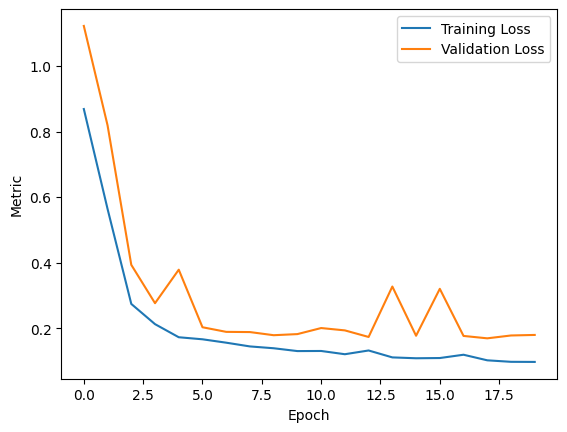

In [41]:

LectureModel = copy.deepcopy(lectureModel)
LectureHousingTrainer = Train_Model(LectureModel, nn.MSELoss(), torch.optim.SGD(LectureModel.parameters(), lr=0.01, momentum=0.9), nn.MSELoss(), "Regression",  device_to_use)

start_time = datetime.now()

LectureHousingTrainer.fit(trainLoaderHousing, validateLoaderHousing, 20)
end_time = datetime.now()

print("Time Taken to Train:", end_time - start_time)
### PLOTTING METRICS
plt.plot(LectureHousingTrainer.Metrics['Training_Loss'], label='Training Loss')
plt.plot(LectureHousingTrainer.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

100%|██████████| 10/10 [00:00<00:00, 25.14it/s]


Current Epoch: 1
Training_Loss: 0.9037358701229096  | Validation_Loss: 1.0443241596221924


100%|██████████| 10/10 [00:00<00:00, 27.20it/s]


Current Epoch: 2
Training_Loss: 0.8078932464122772  | Validation_Loss: 1.0734533071517944


100%|██████████| 10/10 [00:00<00:00, 23.03it/s]


Current Epoch: 3
Training_Loss: 0.44318895414471626  | Validation_Loss: 0.9243905146916708


100%|██████████| 10/10 [00:00<00:00, 26.72it/s]


Current Epoch: 4
Training_Loss: 0.2354426808655262  | Validation_Loss: 0.2542944401502609


100%|██████████| 10/10 [00:00<00:00, 25.14it/s]


Current Epoch: 5
Training_Loss: 0.19621551930904388  | Validation_Loss: 0.22517694532871246


100%|██████████| 10/10 [00:00<00:00, 26.48it/s]


Current Epoch: 6
Training_Loss: 0.1527519330382347  | Validation_Loss: 0.2612552245457967


100%|██████████| 10/10 [00:00<00:00, 25.35it/s]


Current Epoch: 7
Training_Loss: 0.16154221519827844  | Validation_Loss: 0.2244905928770701


100%|██████████| 10/10 [00:00<00:00, 27.15it/s]


Current Epoch: 8
Training_Loss: 0.14253699406981468  | Validation_Loss: 0.17123274753491083


100%|██████████| 10/10 [00:00<00:00, 25.60it/s]


Current Epoch: 9
Training_Loss: 0.11301840282976627  | Validation_Loss: 0.16953177750110626


100%|██████████| 10/10 [00:00<00:00, 15.02it/s]


Current Epoch: 10
Training_Loss: 0.12126475758850574  | Validation_Loss: 0.18024075527985892


100%|██████████| 10/10 [00:00<00:00, 14.56it/s]


Current Epoch: 11
Training_Loss: 0.1173060305416584  | Validation_Loss: 0.21855823695659637


100%|██████████| 10/10 [00:00<00:00, 21.53it/s]


Current Epoch: 12
Training_Loss: 0.09553936384618282  | Validation_Loss: 0.23200559616088867


100%|██████████| 10/10 [00:00<00:00, 26.00it/s]


Current Epoch: 13
Training_Loss: 0.07987673450261354  | Validation_Loss: 0.17970347901185355


100%|██████████| 10/10 [00:00<00:00, 26.60it/s]


Current Epoch: 14
Training_Loss: 0.07152354307472705  | Validation_Loss: 0.20761009057362875


100%|██████████| 10/10 [00:00<00:00, 27.64it/s]


Current Epoch: 15
Training_Loss: 0.06240518055856228  | Validation_Loss: 0.15813466534018517


100%|██████████| 10/10 [00:00<00:00, 27.20it/s]


Current Epoch: 16
Training_Loss: 0.0696444196626544  | Validation_Loss: 0.21665399769941965


100%|██████████| 10/10 [00:00<00:00, 25.75it/s]


Current Epoch: 17
Training_Loss: 0.05478843040764332  | Validation_Loss: 0.3514442245165507


100%|██████████| 10/10 [00:00<00:00, 25.90it/s]


Current Epoch: 18
Training_Loss: 0.05347675196826458  | Validation_Loss: 0.17838379740715027


100%|██████████| 10/10 [00:00<00:00, 26.80it/s]


Current Epoch: 19
Training_Loss: 0.06789169684052468  | Validation_Loss: 0.22855696827173233


100%|██████████| 10/10 [00:00<00:00, 25.91it/s]

Current Epoch: 20
Training_Loss: 0.06129190716892481  | Validation_Loss: 0.20305866996447244
Time Taken to Train: 0:00:10.690065


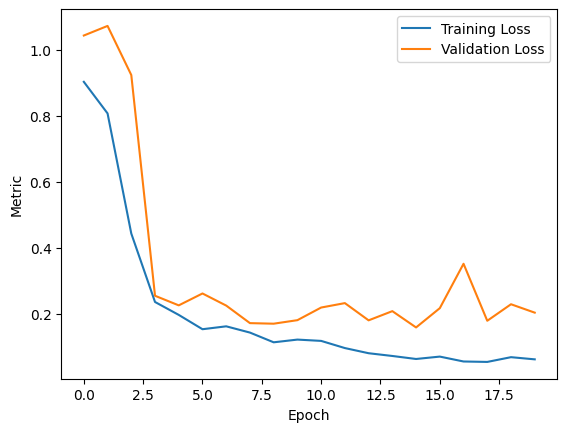

In [42]:
base_housingModel = copy.deepcopy(sale_predictor)
ComplexHousingTrainer = Train_Model(base_housingModel, nn.MSELoss(), torch.optim.SGD(base_housingModel.parameters(), lr=0.01, momentum=0.9), nn.MSELoss(), "Regression",  device_to_use)

start_time = datetime.now()

ComplexHousingTrainer.fit(trainLoaderHousing, validateLoaderHousing, 20)
end_time = datetime.now()

print("Time Taken to Train:", end_time - start_time)
### PLOTTING METRICS
plt.plot(ComplexHousingTrainer.Metrics['Training_Loss'], label='Training Loss')
plt.plot(ComplexHousingTrainer.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

### How about the model complexity comparison and training time?
The new model shows better accuracy compared to the model built during the class lectures.